In [5]:
# !pip install tqdm

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
from tqdm import tqdm
from IPython.display import Audio
from IPython.display import clear_output
import math
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20,10)

In [11]:
base_dir = 'data'
file_paths = []
# for i in tqdm(os.listdir(base_dir)[:30]):
for i in tqdm(os.listdir(base_dir)[:4]):
    try:
        for audio in os.listdir(os.path.join(base_dir,i)):
            file_paths.append(os.path.join(base_dir,i,audio))
    except Exception as e:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 102.69it/s]


In [12]:
len(file_paths)

2000

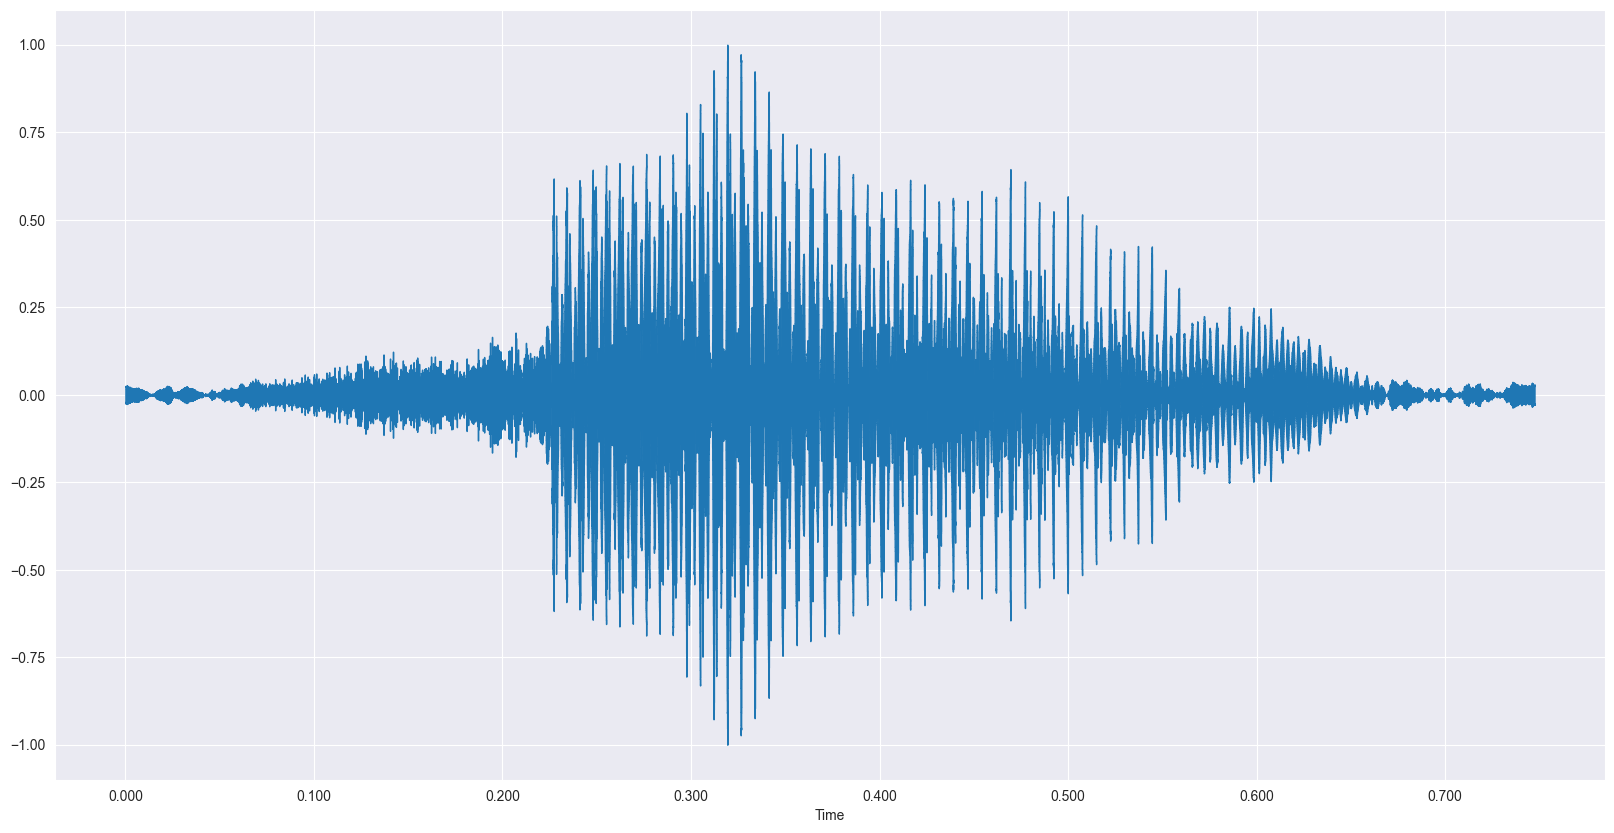

In [13]:
audio,sr = librosa.load(file_paths[0])
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

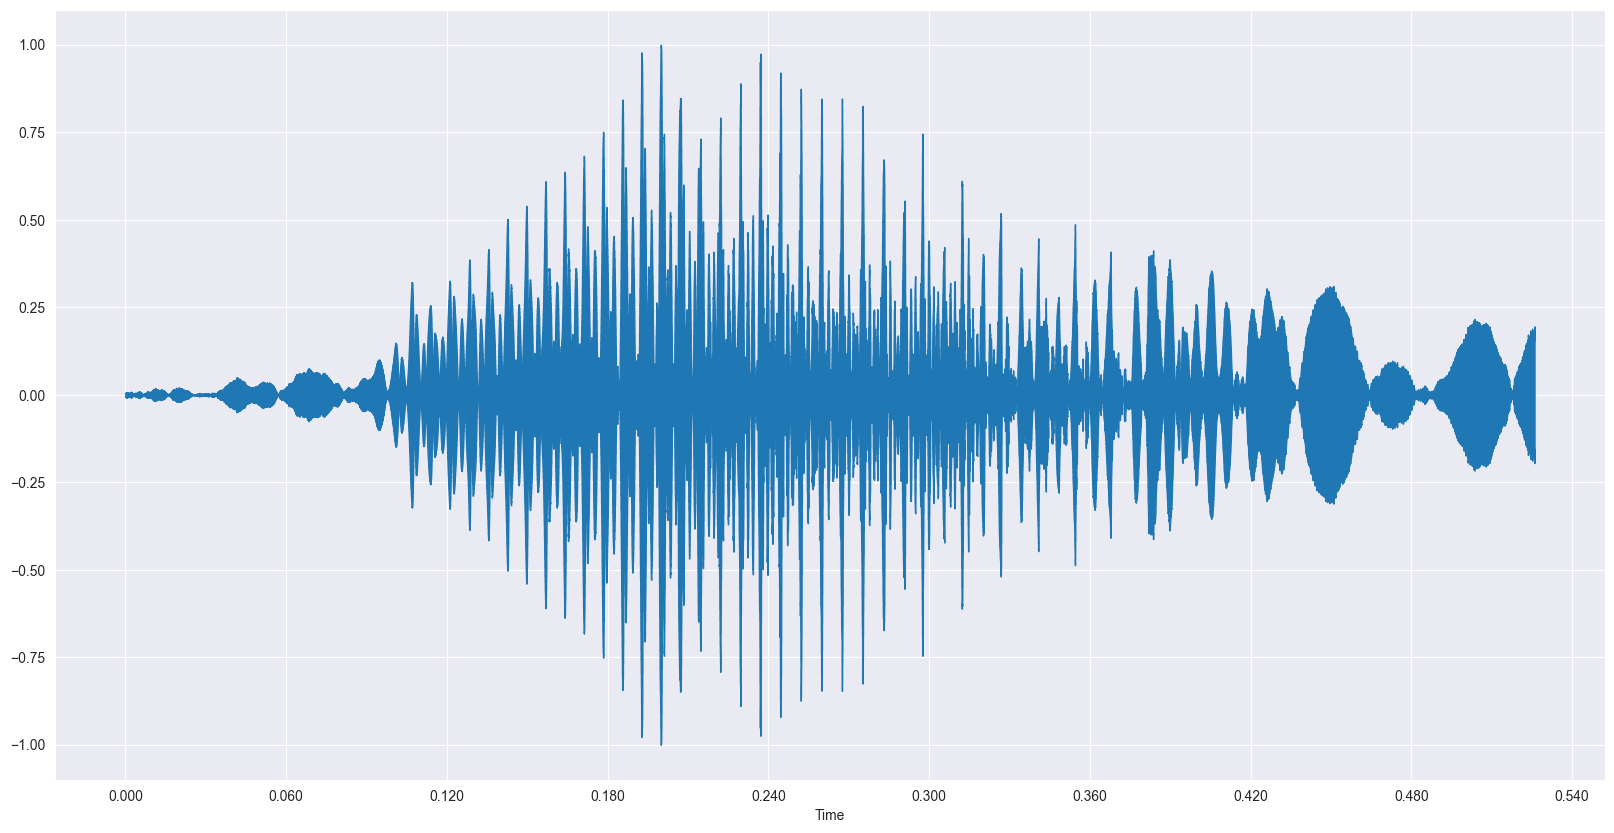

In [14]:
audio2,sr = librosa.load(file_paths[52])
audio2 = librosa.util.normalize(audio2)
audiowgt2 = Audio(data=audio2,rate=sr)
display(audiowgt2)
librosa.display.waveshow(audio2,sr=sr)

In [15]:
def load_audio(path):
    '''Loads audio and also center pads them to max len 1 second

    Args:
    path: Audio File Path

    Returns:
    Audio : center padded audio with max len 1 second
    '''
    audio,sr = librosa.load(path)
    # lets pad for 1 second
    len_audio = librosa.get_duration(y=audio,sr=sr)
    if len_audio >= 1:
        return audio[:1*sr],sr
    else:
        pad_audio = librosa.util.pad_center(data=audio,size=(1*sr))
        return pad_audio,sr

In [16]:
def get_white_noise(signal,SNR=40) :
    '''Generates White noise for signal.

    Args:
    signal : Audio signal for which noise is to be generated
    SNR : Signal to Noise value (>1 , <100)

    Returns:
    noise: noise data'''
    RMS_s=math.sqrt(np.mean(signal**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [17]:
def get_mfcc(path,snr=40,aug=False):
    '''Get mel-frequency cepstral coefficients for the audio frame

    Args:
    path: Audio File Path
    snr: Signal to noise value >1 , <100
    aug: bool , whether to return augumented mfccs'''
    audio,sr = load_audio(path)
    audio = librosa.util.normalize(audio)
    mfcc = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
    if aug:
        aug_audio = audio + get_white_noise(audio,snr)
        aug_mfcc = librosa.feature.mfcc(y=aug_audio,sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
        return [np.expand_dims(mfcc,axis=-1),np.expand_dims(aug_mfcc,axis=-1)]
    return np.expand_dims(mfcc,axis=-1)

In [20]:
file_paths[1]

'data\\01\\0_01_1.wav'

In [22]:
X = []
Y = []
k = 0
aug=True
for i in file_paths:
    k = k+1
    display(k)
    clss = i.split('\\')[-1].split('.')[0].split('_')[0]    
    mfcs = get_mfcc(i,aug=True)
    for j in mfcs:
        X.append(j)
        Y.append(int(clss))
    clear_output(wait=True)

2000

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
xt,xv,yt,yv = train_test_split(np.asarray(X),np.asarray(Y),test_size=0.2,random_state=42)

In [25]:
def plot(history,epochs,model=None,save=False):
    hist = history.history
    plt.subplot(1,2,1)
    plt.title('Loss Graph')
    plt.plot(range(epochs),hist['loss'],color='r',label='Loss')
    plt.plot(range(epochs),hist['val_loss'],color='g',label='Val_loss')
    plt.legend()
    plt.tight_layout()
    plt.subplot(1,2,2)
    plt.title('Accuracy Graph')
    plt.plot(range(epochs),hist['accuracy'],color='r',label='accuracy')
    plt.plot(range(epochs),hist['val_accuracy'],color='g',label='Val_accuracy')
    plt.legend()
    plt.tight_layout()
    plt.suptitle('Loss-Accuracy Plot')
    l_low , a_max = min(hist['val_loss']) , max(hist['val_accuracy'])
    if save and model != None:
        plt.savefig(f'./progress/history plot/lmin{l_low}_amin{a_max}.png')
        model.save(f'./progress/model/lmin{l_low}_amin{a_max}.h5')
        print('Plot and Model Saved')

In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D ,AveragePooling2D , GlobalAvgPool2D , Dense ,InputLayer

In [27]:
Input_shape = xv[0].shape
Input_shape

(13, 44, 1)

In [28]:
from tensorflow.keras.layers import Conv2D ,AveragePooling2D , GlobalAvgPool2D , Dense ,InputLayer, Dropout # Added Dropout to the import statement

In [29]:
model = tf.keras.models.Sequential([
    InputLayer(input_shape=Input_shape),
    Conv2D(64,(3),padding='valid',activation='relu',name='conv_1'),
    Conv2D(64,(3),padding='valid',activation='relu',name='conv_2'),
    AveragePooling2D(pool_size=(3),strides=(2),padding='same',name='avg_1'),
    Conv2D(128,(3),padding='valid',activation='relu',name='conv_3'),
    GlobalAvgPool2D(),
    Dropout(0.3),
    Dense(64,activation='relu'),
    Dense(32,activation='relu'),
    Dense(10,activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])
model.summary()

C:\Users\MD RAHATUL RABBI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                      │ (None, 11, 42, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, 9, 40, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ avg_1 (AveragePooling2D)             │ (None, 5, 20, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_3 (Conv2D)                      │ (None, 3, 18, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,090 (476.91 KB)

 Trainable params: 122,090 (476.91 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [32]:
history = model.fit(xt,yt,batch_size=32,epochs=10,validation_data=(xv,yv),callbacks=[es_cb])

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9983 - loss: 0.0092 - val_accuracy: 1.0000 - val_loss: 0.0026
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.9940 - loss: 0.0140 - val_accuracy: 0.9987 - val_loss: 0.0043
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9921 - loss: 0.0198 - val_accuracy: 1.0000 - val_loss: 6.9731e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.9985 - loss: 0.0057 - val_accuracy: 1.0000 - val_loss: 4.3627e-04
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.9987 - val_loss: 0.0033
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 7.1187e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9977 - loss: 0.0093 - val_accuracy: 0.9975 - val_loss: 0.0109
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.9972 - loss: 0.01

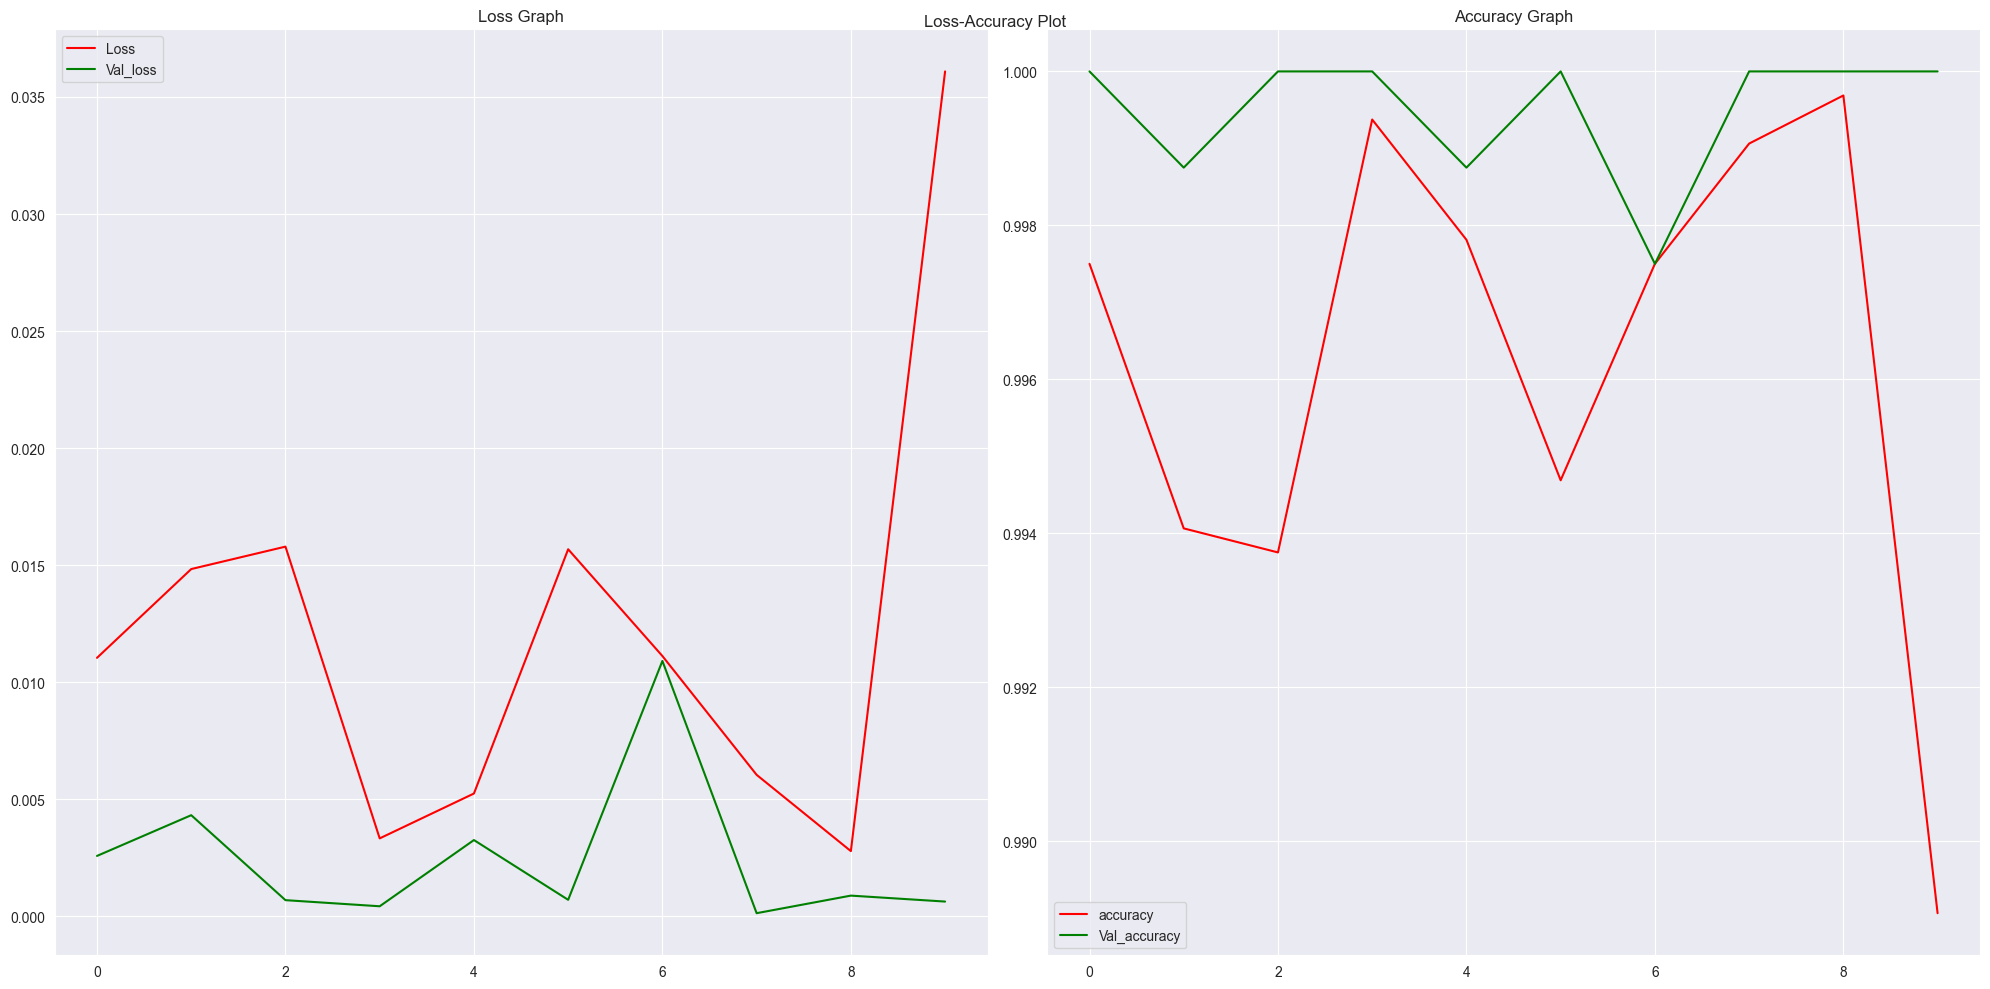

In [33]:
plot(history,len(history.history['loss']))

In [34]:
pred = model.predict(xt)
pred.shape

100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


(3200, 10)

In [35]:
preds = [np.argmax(i) for i in pred]

In [36]:
from sklearn.metrics import classification_report

In [37]:
print(classification_report(yt,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       1.00      1.00      1.00       325
           2       1.00      1.00      1.00       306
           3       1.00      1.00      1.00       319
           4       1.00      1.00      1.00       307
           5       1.00      1.00      1.00       316
           6       1.00      1.00      1.00       344
           7       1.00      1.00      1.00       315
           8       1.00      1.00      1.00       317
           9       1.00      1.00      1.00       338

    accuracy                           1.00      3200
   macro avg       1.00      1.00      1.00      3200
weighted avg       1.00      1.00      1.00      3200



In [38]:
from sklearn.metrics import confusion_matrix

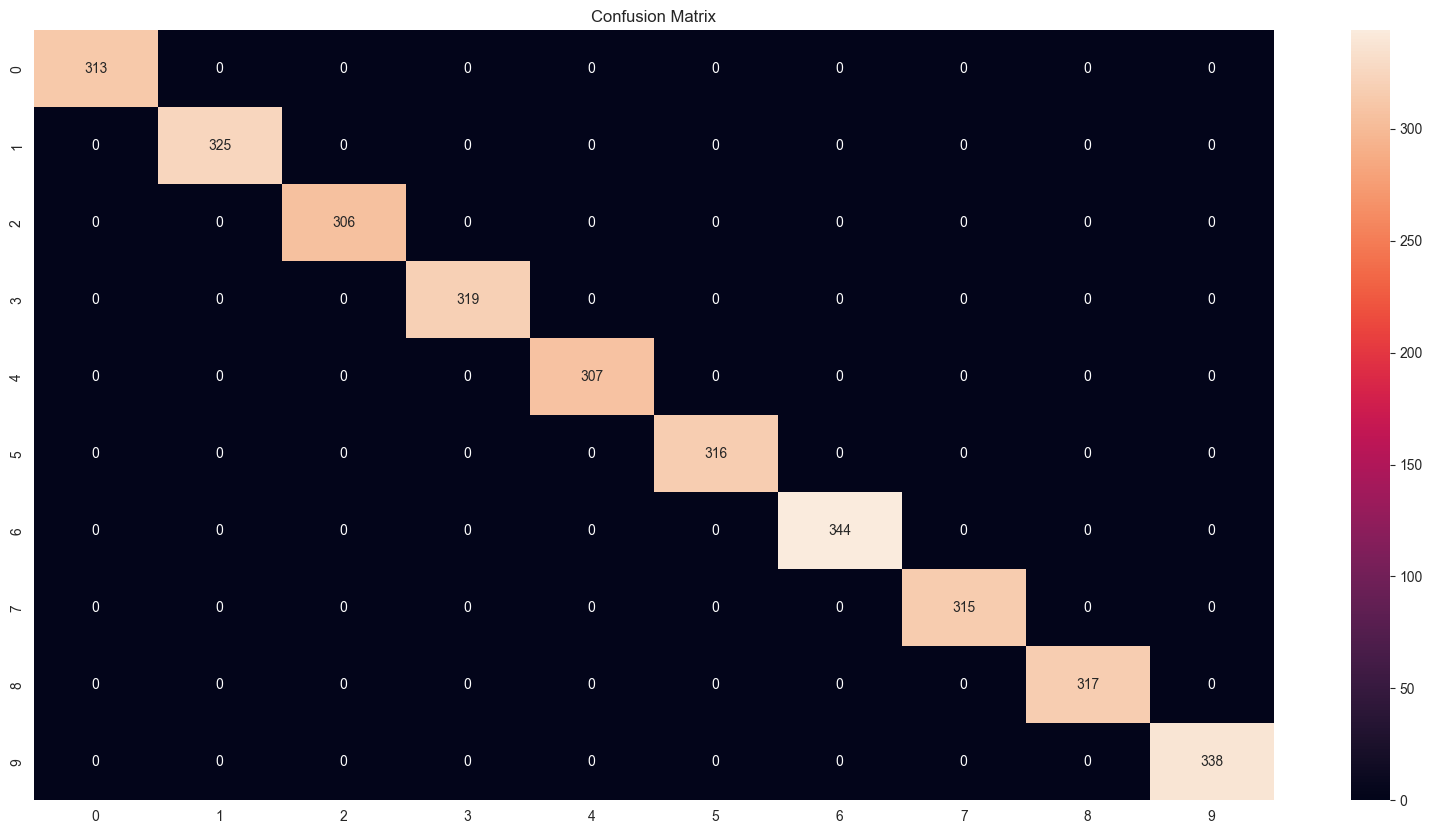

In [39]:
cfm = confusion_matrix(yt,preds)
sns.heatmap(cfm,annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()